In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import scienceplots
import h5py

import sys
sys.path.append('/n/home05/victoriaono/CAMELS/')
sys.path.append('/n/home05/victoriaono/CAMELS/model/utils')
from model import vdm_model, networks
from utils import compute_pk

device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

In [3]:
torch.cuda.empty_cache()

In [2]:
def load_model(ckpt=None,
        cropsize = 256,
        gamma_min = -13.3,
        gamma_max = 13.3,
        embedding_dim = 48,
        norm_groups = 8,
        use_fourier_features = False,
        add_attention = False,
        noise_schedule = 'learned_linear',
        n_blocks = 4
):
    vdm = vdm_model.LightVDM(
            score_model=networks.UNetVDM(
                gamma_min=gamma_min,
                gamma_max=gamma_max,
                embedding_dim=embedding_dim,
                norm_groups=norm_groups,
                n_blocks=n_blocks,
                add_attention=add_attention,
                use_fourier_features=use_fourier_features
            ),
            dataset='IllustrisTNG',
            gamma_min=gamma_min,
            gamma_max=gamma_max,
            image_shape=(1,cropsize,cropsize),
            noise_schedule=noise_schedule,
        )
    vdm = vdm.to(device=device)
    if ckpt is not None:
        state_dict=torch.load(ckpt)["state_dict"]
        vdm.load_state_dict(state_dict)
    return vdm.eval()


In [3]:
#input normalization
mean_input=0.11826974898576736
std_input=1.0741989612579346
mean_target=10.971004486083984
std_target=0.5090954303741455

In [4]:
with h5py.File("/n/holystore01/LABS/itc_lab/Lab/Camels/2d_from_3d/CV256.h5","r") as h5:
    mass_mstar=np.array(h5["mstar_z=0.0"])
    mass_cdm=np.array(h5["mcdm_z=0.0"])
mass_mstar = np.log10(mass_mstar+1)
mass_mstar_normed = torch.Tensor((mass_mstar - mean_input) / std_input).unsqueeze(1).unsqueeze(1)
mass_cdm = np.log10(mass_cdm)
mass_cdm_normed = torch.Tensor((mass_cdm - mean_target) / std_target).unsqueeze(1).unsqueeze(1)

In [5]:
plt.style.use(['science'])
loss_colors = ['#1f77b4','#aec7e8','#2ca02c','#98df8a','#d62728','#ff9896','#9467bd','#c5b0d5','#e377c2','#f7b6d2']

In [6]:
def generate_samples(vdm, conditioning, batch_size=10, n=10):

    star = conditioning[0]
    star_fields = star.expand(batch_size, star.shape[0], star.shape[1], star.shape[2])

    maps = [] # 10 tensors of shape ([10, 1, img_shape, img_shape])
    # draw n samples with the same conditioning
    torch.manual_seed(13)
    for _ in range(n):
        sample = vdm.draw_samples(
            conditioning=star_fields,
            batch_size=batch_size,
            n_sampling_steps=vdm.hparams.n_sampling_steps,
            )
        maps.append(sample)
        
    return maps

In [7]:
epochs = np.arange(0, 300000, step=6000, dtype=int)

In [65]:
ablations = {}

In [9]:
ablation_generated_pks, ablation_cross_true_pks = {}, {}
for ablation in ablations:
    ablation_generated_pks[ablation] = []
    ablation_cross_true_pks[ablation] = []
    for url, start, end in ablations[ablation]:
        generated_pks, cross_true_pks = [], []
        for epoch in range(start, end+1, 6):
            ckpt = f'/n/holyscratch01/eisenstein_lab/Users/victoriaono/debiasing/{url}/checkpoints/latest-epoch={epoch}-step={(epoch+1)*1000}.ckpt'
            params = {
                'add_attention': True if ablation == "attn" else False,
                'use_fourier_features': True if ablation == "ff" else False,
                'noise_schedule': "fixed_linear" if ablation == "fixed" else "learned_linear",
                'gamma_max': 5.0 if ablation == "fixed" else 13.3,
                'n_blocks': 2 if ablation == "blocks" else 4,
                'embedding_dim': 24 if ablation == "half_embedding" else 48
            }
            vdm = load_model(ckpt, **params)
            generated_normed = torch.vstack(
                generate_samples(vdm,
                    conditioning=mass_mstar_normed[0].to(device), 
                    batch_size=20, 
                    n=5,
                )
            )
            generated = generated_normed * std_target + mean_target
            generated_pk, cross_true_pk = [], []
            for sample in generated:
                generated_pk.append(compute_pk(10**sample.cpu().numpy()[None])[1])
                k, cross_true_sample = compute_pk(10**mass_cdm[0][None,None], 10**sample[None].cpu().numpy())
                cross_true_pk.append(cross_true_sample)
            generated_pks.append(torch.stack(generated_pk))
            cross_true_pks.append(torch.stack(cross_true_pk))
        ablation_generated_pks[ablation] += torch.stack(generated_pks)
        ablation_cross_true_pks[ablation] += torch.stack(cross_true_pks)
        print(f"{ablation} {epoch} complete!")
    assert len(ablation_cross_true_pks[ablation]) == 50
    torch.save(ablation_generated_pks[ablation], f'arrays/illustris-{ablation}_generated_pk.pt')
    torch.save(ablation_cross_true_pks[ablation], f'arrays/illustris-{ablation}_cross_true_pk.pt')

half_embedding 299 complete!


In [8]:
ablation_generated_pks = {}
ablation_cross_true_pks = {}

In [9]:
ablation_generated_pks['ff'] = torch.load('arrays/illustris-ff_generated_pk.pt')
ablation_cross_true_pks['ff'] = torch.load('arrays/illustris-ff_cross_true_pk.pt')
ablation_generated_pks['base'] = torch.load('arrays/illustris-base_generated_pk.pt')
ablation_cross_true_pks['base'] = torch.load('arrays/illustris-base_cross_true_pk.pt')
ablation_generated_pks['fixed'] = torch.load('arrays/illustris-fixed_generated_pk.pt')
ablation_cross_true_pks['fixed'] = torch.load('arrays/illustris-fixed_cross_true_pk.pt')
ablation_generated_pks['attn'] = torch.load('arrays/illustris-attn_generated_pk.pt')
ablation_cross_true_pks['attn'] = torch.load('arrays/illustris-attn_cross_true_pk.pt')
ablation_generated_pks['blocks'] = torch.load('arrays/illustris-blocks_generated_pk.pt')
ablation_cross_true_pks['blocks'] = torch.load('arrays/illustris-blocks_cross_true_pk.pt')
ablation_generated_pks['half_embedding'] = torch.load('arrays/illustris-half_embedding_generated_pk.pt')
ablation_cross_true_pks['half_embedding'] = torch.load('arrays/illustris-half_embedding_cross_true_pk.pt')

In [10]:
k, dm_pk = compute_pk(10**mass_cdm[0][None,None],)
k, cross_stars_true = compute_pk(10**mass_mstar[0][None,None] - 1., 10**mass_cdm[0][None,None])

In [11]:
k_idx = np.unique(np.arange(len(k))[np.logspace(0,np.log10(len(k)),50).astype(int)])

In [12]:
cross_corr = {}
for ablation in ['base', 'ff', 'fixed', 'attn', 'blocks', 'half_embedding']:
    cross_corr[ablation] = []
    cross_true_pks = ablation_cross_true_pks[ablation]
    generated_pks = ablation_generated_pks[ablation]

    # add the mean of cross correlation coefficients for each checkpoint
    for i in range(len(cross_true_pks)):
        coeffs = cross_true_pks[i] / np.sqrt(dm_pk) / np.sqrt(generated_pks[i]) # between -1 and 1
        cross_corr[ablation].append(coeffs.mean().item())

In [51]:
generated_pks = ablation_generated_pks['base']
plt.fill_between(k[k_idx], np.percentile(generated_pks[40], 10, axis=0)[k_idx], np.percentile(generated_pks[40],90, axis=0)[k_idx], alpha=0.2, color='blue')
plt.loglog(k[k_idx], dm_pk[k_idx], color='red')

In [13]:
labels = {
    'base': 'Base',
    'attn': 'Attention block',
    'ff': 'Fourier features',
    'fixed': 'Fixed linear schedule',
    'blocks': '2 blocks',
    'half_embedding': '24-dimension embedding'
}

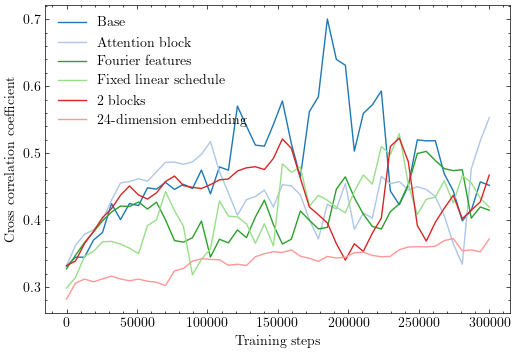

In [14]:
# Plot cross correlation coefficient means across checkpoints for every ablation
fig, ax = plt.subplots(figsize=(6,4))
window_width = 3
x = np.linspace(0, 300000, num=50-window_width+1)
for i, ablation in enumerate(labels):
    cumsum_vec = np.cumsum(np.insert(cross_corr[ablation], 0, 0))
    # ax.plot(cross_corr[ablation])
    smoothed = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    ax.plot(x, smoothed, label=labels[ablation], color=loss_colors[i])
    ax.set_ylabel('Cross correlation coefficient')
    ax.set_xlabel('Training steps')
ax.legend(loc='upper left')

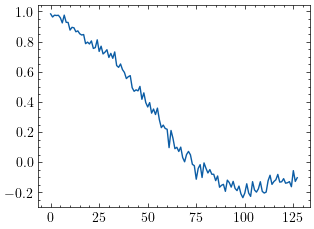

In [44]:
coeffs = cross_true_pks[35] / np.sqrt(dm_pk) / np.sqrt(generated_pks[35])
plt.plot(coeffs[0])

In [105]:
fig.savefig('../images/paper/cross_corr.png', dpi=300)
fig.savefig('../images/paper/cross_corr.pdf')